# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [58]:
import pandas as pd
import numpy as np
import plotly
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
% matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor


In [59]:
from plotly import __version__

In [60]:
import cufflinks as cf

In [61]:
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

In [62]:
init_notebook_mode(connected=True)

<

In [63]:
cf.go_offline()

<

In [64]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [65]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Exploring Customer Transaction Dataset

In [66]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [67]:
# Printing important statistic about the dataset.
# Dataset consist of 4 cols and 306,534 rows with no missing values

print(transcript.shape)
print(transcript.info())
print(transcript.describe())
print(transcript.isnull())

(306534, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000
        event  person   time  value
0       False   False  False  False
1       False   False  False  False
2       False   False  False  False
3       False   False  False  False
4       False   False  False  False
5       False   False  False  False
6       False   False  False  False
7       False   False  False  False
8       False   False  False  False
9       False   False  False  False
10      False   False  False  False
11      False   False  False  False
12      False   False  False  False

### Let's review the information below.
 As we can see that there was 138,953 made. 76,277 customer recieved the offer, 57,725 view offer and 33,579 completed which is only 12%
 #### Questions.
 1.How can we get more customer to complete offer?

In [68]:
transcript["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [69]:
# transaction event in percentage
transcript["event"].value_counts()/len(transcript)*100

transaction        45.330371
offer received     24.883700
offer viewed       18.831516
offer completed    10.954413
Name: event, dtype: float64

In [70]:
transcript["time"].value_counts()

408    17030
576    17015
504    16822
336    16302
168    16150
0      15561
414     3583
510     3514
582     3484
588     3222
516     3153
420     3146
342     3017
594     2937
426     2908
174     2823
522     2783
600     2739
432     2690
180     2659
348     2655
438     2591
606     2585
528     2569
6       2506
534     2465
354     2422
186     2406
612     2375
444     2367
       ...  
270     1294
264     1260
252     1260
690     1260
96      1248
90      1235
276     1206
288     1199
102     1193
282     1175
120     1168
714     1130
702     1115
114     1106
108     1104
300     1073
708     1048
306     1034
312     1031
294     1010
126      983
324      968
138      968
144      955
132      952
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64

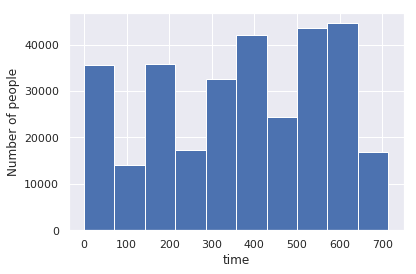

In [71]:
plt.hist(transcript['time'],bins=10)
plt.ylabel('Number of people');
plt.xlabel('time');
plt.show()

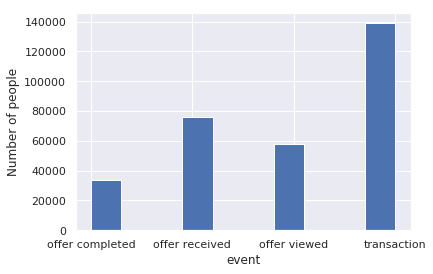

In [72]:
plt.hist(transcript['event'],bins=10)
plt.ylabel('Number of people');
plt.xlabel('event');
plt.show()

### Review Portfolio dataset

In [73]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [74]:
# Printing important statistic about the dataset.
# Dataset consist of 7 cols and 10 rows with no missing values
# split channels into 4 cols
# no missing values
print(portfolio.shape)
print(portfolio.info())
print(portfolio.describe())
print(portfolio.isnull())

(10, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes
None
       difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000
   channels  difficulty  duration     id  offer_type  reward
0     False       False     False  False       False   False
1     False       False     False  False       False   False
2     False       False     False  False       False   False
3     False       False     Fals

In [75]:
portfolio["channels"]

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [76]:
#splitting channels into columns
portfolio["channel_web"] = portfolio["channels"].apply(lambda x : 1 if 'web' in x else 0)
portfolio["channel_email"] = portfolio["channels"].apply(lambda x : 2 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio["channels"].apply(lambda x: 3 if 'mobile' in x else 0)
portfolio["channel_social"] = portfolio["channels"].apply(lambda x: 4 if "social" in x else 0)
portfolio[["channels","channel_web","channel_email","channel_mobile","channel_social"]]

,channels,channel_web,channel_email,channel_mobile,channel_social
0,"[email, mobile, social]",0,2,3,4
1,"[web, email, mobile, social]",1,2,3,4
2,"[web, email, mobile]",1,2,3,0
3,"[web, email, mobile]",1,2,3,0
4,"[web, email]",1,2,0,0
5,"[web, email, mobile, social]",1,2,3,4
6,"[web, email, mobile, social]",1,2,3,4
7,"[email, mobile, social]",0,2,3,4
8,"[web, email, mobile, social]",1,2,3,4
9,"[web, email, mobile]",1,2,3,0


In [77]:
portfolio.drop("channels",axis=1, inplace= True)
portfolio.head()

,difficulty,duration,id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,2,3,4
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,2,3,4
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,2,3,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,2,3,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,2,0,0


In [78]:
#lets review offer_type
portfolio["offer_type"].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

#### It seems like bogo take less time for customer to open and view offer.

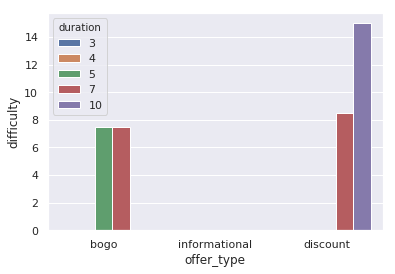

In [79]:
# customer takes about 7 days to complete the bogo offer and over 8  days for the discount
# difficulty min requirement to complete offer
#duration time takes customer to open offer

ax = sns.barplot(x ='offer_type', y ='difficulty', data = portfolio, ci = None, hue ='duration')

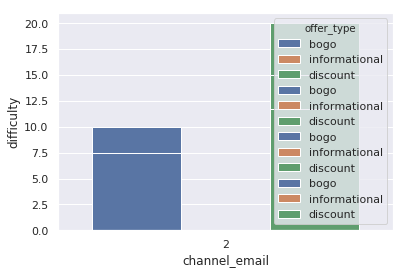

In [80]:
ax = sns.barplot(x ='channel_web', y ='difficulty', data = portfolio, ci = None, hue ='offer_type')
ax = sns.barplot(x ='channel_mobile', y ='difficulty', data = portfolio, ci = None, hue ='offer_type')
ax = sns.barplot(x ='channel_social', y ='difficulty', data = portfolio, ci = None, hue ='offer_type')
ax = sns.barplot(x ='channel_email', y ='difficulty', data = portfolio, ci = None, hue ='offer_type')

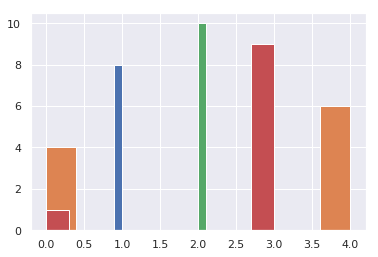

In [81]:

# Mobile and social look like the most active medium.
#email and web take longer time- most customer rarely check their email unless it an emergency

plt.hist(portfolio['channel_web'],bins=10)#Blue
plt.hist(portfolio['channel_social'],bins=10)#orange
plt.hist(portfolio['channel_email'],bins=10)#green
plt.hist(portfolio['channel_mobile'],bins=10)#Red

plt.show()

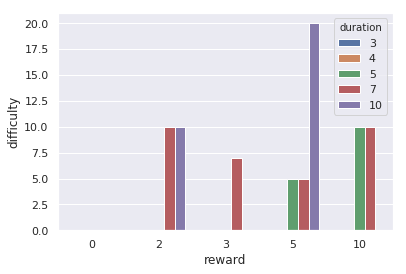

In [82]:
# reward  are given to complete the offer
# duration time take to complete the offer
#difficulty time it take customer to open offer

ax = sns.barplot(x ='reward', y ='difficulty', data = portfolio, ci = None, hue ='duration')


In [83]:
print(portfolio['reward'].describe() )
print('***-----------------****')
print(portfolio['duration'].describe())
print('***-----------------****')
print(portfolio['difficulty'].describe())

count    10.000000
mean      4.200000
std       3.583915
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      10.000000
Name: reward, dtype: float64
***-----------------****
count    10.000000
mean      6.500000
std       2.321398
min       3.000000
25%       5.000000
50%       7.000000
75%       7.000000
max      10.000000
Name: duration, dtype: float64
***-----------------****
count    10.000000
mean      7.700000
std       5.831905
min       0.000000
25%       5.000000
50%       8.500000
75%      10.000000
max      20.000000
Name: difficulty, dtype: float64


#### Exploring customer profile dataset

In [84]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [85]:
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

profile[profile['age'] == 118]

,age,became_member_on,gender,id,income


In [86]:
profile.dropna(inplace=True)
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [87]:
profile.head()

,age,became_member_on,gender,id,income
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [88]:
# dataset consist of 5 cols and 17,000 rows
# missing gender and income inforamtion 2175

print(profile.shape)
print(profile.info())
print(profile.describe())
print(profile.isnull())


(14825, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null float64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 694.9+ KB
None
                age  became_member_on         income
count  14825.000000      1.482500e+04   14825.000000
mean      54.393524      2.016689e+07   65404.991568
std       17.383705      1.188565e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       42.000000      2.016052e+07   49000.000000
50%       55.000000      2.017080e+07   64000.000000
75%       66.000000      2.017123e+07   80000.000000
max      101.000000      2.018073e+07  120000.000000
         age  became_member_on  gender     id  income
1      False             False   False  False   False
3      False    

In [89]:
print(profile['gender'].value_counts)
print(profile['income'].describe())
print(profile['age'].describe())

<bound method IndexOpsMixin.value_counts of 1        F
3        F
5        M
8        M
12       M
13       F
14       M
15       F
16       M
18       M
19       F
20       F
21       M
22       F
24       M
25       F
27       F
28       F
29       M
30       M
31       O
32       M
33       F
34       M
35       F
37       M
38       F
40       M
41       F
42       M
        ..
16963    F
16964    M
16965    M
16966    M
16967    M
16968    M
16970    M
16971    F
16972    F
16973    M
16974    F
16975    F
16976    F
16978    F
16979    F
16981    M
16983    F
16984    F
16985    M
16986    F
16987    M
16988    M
16990    F
16992    F
16993    M
16995    F
16996    M
16997    M
16998    F
16999    F
Name: gender, Length: 14825, dtype: object>
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64
count    14825.000000
mean  

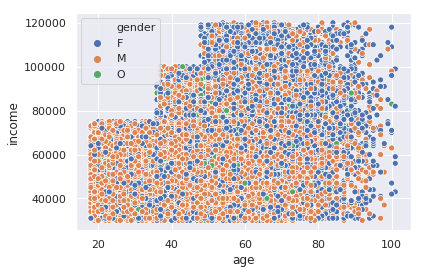

In [90]:
ax = sns.scatterplot(x ='age', y ='income', data = profile, ci=None,hue= "gender" )

plt.show()

### Merging Dataframes and performing EDA
 1. Merge all three dataframe 
 2. fillin Nan value with zero
 3. irrelevant columns
 4. Visualizing data for insightful information 

In [91]:
# merge dataframe

df = pd.merge(profile, transcript, how = 'left', left_on = ['id'], right_on = ['person'])
df.head()

,age,became_member_on,gender,id,income,event,person,time,value
0,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,18,{'amount': 21.51}
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,144,{'amount': 32.28}
2,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
3,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,504,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
4,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,528,{'amount': 23.22}


In [92]:
df.drop('person',axis=1).head()

,age,became_member_on,gender,id,income,event,time,value
0,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,18,{'amount': 21.51}
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,144,{'amount': 32.28}
2,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
3,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,504,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
4,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,528,{'amount': 23.22}


In [93]:
df.shape

(272762, 9)

In [94]:
df1 = pd.merge(df, portfolio, how = 'outer', left_on = ['id'], right_on = ['id'])
df1.head(10)

,age,became_member_on,gender,id,income,event,person,time,value,difficulty,duration,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,18.0,{'amount': 21.51},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,144.0,{'amount': 32.28},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,408.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,504.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,528.0,{'amount': 23.22},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,0610b486422d4921ae7d2bf64640c50b,528.0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,transaction,78afa995795e4d85b5d9ceeca43f5fef,132.0,{'amount': 19.89},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132.0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
df1.shape

(272772, 17)

In [96]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272772 entries, 0 to 272771
Data columns (total 17 columns):
age                 272762 non-null float64
became_member_on    272762 non-null float64
gender              272762 non-null object
id                  272772 non-null object
income              272762 non-null float64
event               272762 non-null object
person              272762 non-null object
time                272762 non-null float64
value               272762 non-null object
difficulty          10 non-null float64
duration            10 non-null float64
offer_type          10 non-null object
reward              10 non-null float64
channel_web         10 non-null float64
channel_email       10 non-null float64
channel_mobile      10 non-null float64
channel_social      10 non-null float64
dtypes: float64(11), object(6)
memory usage: 37.5+ MB


In [97]:
df1.columns

Index(['age', 'became_member_on', 'gender', 'id', 'income', 'event', 'person',
       'time', 'value', 'difficulty', 'duration', 'offer_type', 'reward',
       'channel_web', 'channel_email', 'channel_mobile', 'channel_social'],
      dtype='object')

In [98]:
df1.isnull().sum()

age                     10
became_member_on        10
gender                  10
id                       0
income                  10
event                   10
person                  10
time                    10
value                   10
difficulty          272762
duration            272762
offer_type          272762
reward              272762
channel_web         272762
channel_email       272762
channel_mobile      272762
channel_social      272762
dtype: int64

In [99]:
df1['age'].mean()

53.840696284673086

In [100]:
df1['age'].describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

In [101]:
filt_outliers = df1[(df1['age']<98)]
filt_outliers.head()

,age,became_member_on,gender,id,income,event,person,time,value,difficulty,duration,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,18.0,{'amount': 21.51},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,144.0,{'amount': 32.28},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,408.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,504.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,528.0,{'amount': 23.22},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
filt_outliers.shape

(272246, 17)

In [103]:
df1

,age,became_member_on,gender,id,income,event,person,time,value,difficulty,duration,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,18.0,{'amount': 21.51},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,144.0,{'amount': 32.28},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,408.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,504.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,528.0,{'amount': 23.22},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,0610b486422d4921ae7d2bf64640c50b,528.0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,transaction,78afa995795e4d85b5d9ceeca43f5fef,132.0,{'amount': 19.89},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132.0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
new_df =df1.fillna({
        'event': 'no event',
        'offer_type':'no offer',
        'gender':'na',
        'become_member_on':'na',
        'income':0,
        'age':0,
        'person':0,
        'time':0,
})

new_df

,age,became_member_on,gender,id,income,event,person,time,value,difficulty,duration,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,18.0,{'amount': 21.51},NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
1,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,144.0,{'amount': 32.28},NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
2,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,408.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
3,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,0610b486422d4921ae7d2bf64640c50b,504.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
4,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,0610b486422d4921ae7d2bf64640c50b,528.0,{'amount': 23.22},NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
5,55.0,20170715.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer completed,0610b486422d4921ae7d2bf64640c50b,528.0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
6,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
7,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
8,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,transaction,78afa995795e4d85b5d9ceeca43f5fef,132.0,{'amount': 19.89},NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN
9,75.0,20170509.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132.0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,NaN,NaN,no offer,NaN,NaN,NaN,NaN,NaN


In [105]:
new_df.head()
print(new_df.shape)

(272772, 17)


ValueError: max must be larger than min in range parameter.

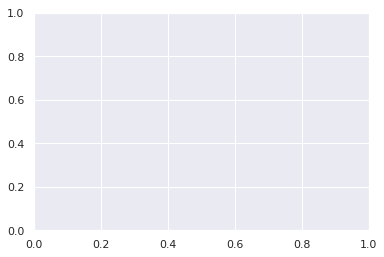

In [107]:
plt.hist(df1['age'],bins=300)
plt.ylabel('Number of people');
plt.xlabel('Age Group');
plt.show()

ValueError: max must be larger than min in range parameter.

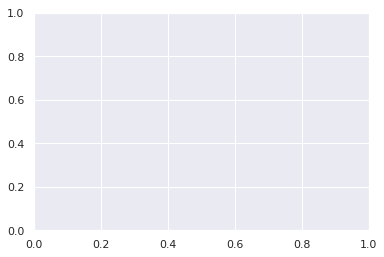

In [108]:
plt.hist(df1['income'],bins=30)
plt.ylabel('Number of people');
plt.xlabel('Income Group');
plt.show()

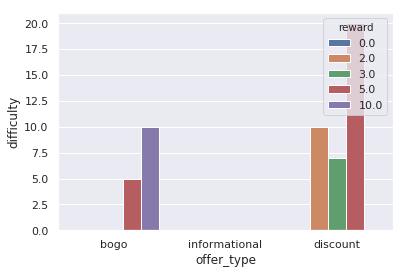

In [109]:
ax = sns.barplot(x ='offer_type', y ='difficulty', data = df1, ci=None,hue ='reward')

ValueError: max must be larger than min in range parameter.

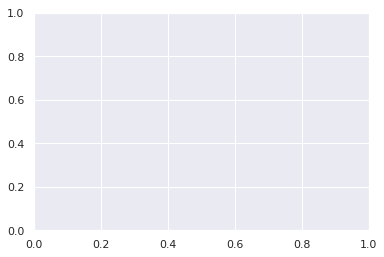

In [110]:
# reward given for completing an offer
# mini requirement spend to complete an offer

plt.hist(df1['reward'],bins=10)
plt.ylabel('difficulty');
plt.xlabel('reward');
plt.show()

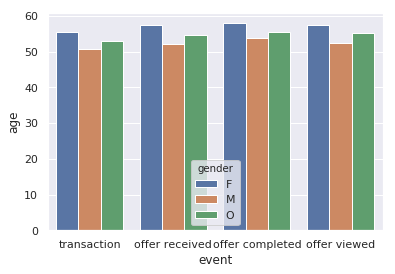

In [111]:
ax = sns.barplot(x ='event', y ='age', data = df1, ci=None,hue ='gender')

ValueError: max must be larger than min in range parameter.

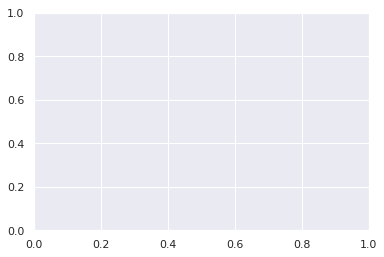

In [112]:
plt.hist(df1['time'],bins=300)
#plt.hist(df1['time'], RANGE( min value, max value))
plt.show()

In [ ]:
sns.pairplot(df1)
sns.set(rc={'figure.figsize':(15,10)})

In [114]:
df1['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [115]:
df2 = df1

In [116]:
df1.drop(['person'], axis=1,inplace=True)

In [117]:
df1["became_member_on"] = pd.to_datetime(df1["became_member_on"])

In [118]:
df1.head()

,age,became_member_on,gender,id,income,event,time,value,difficulty,duration,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,55.0,1970-01-01 00:00:00.020170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,18.0,{'amount': 21.51},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55.0,1970-01-01 00:00:00.020170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,144.0,{'amount': 32.28},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,1970-01-01 00:00:00.020170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,408.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55.0,1970-01-01 00:00:00.020170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,offer received,504.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55.0,1970-01-01 00:00:00.020170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,transaction,528.0,{'amount': 23.22},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
df1['became_member_on'].value_counts().head()

1970-01-01 00:00:00.020171207    635
1970-01-01 00:00:00.020171212    631
1970-01-01 00:00:00.020171007    628
1970-01-01 00:00:00.020170819    605
1970-01-01 00:00:00.020180125    597
Name: became_member_on, dtype: int64

In [120]:
df1.event.value_counts()/len(df1)*100

transaction        45.443447
offer received     24.379702
offer viewed       18.279002
offer completed    11.894183
Name: event, dtype: float64

In [121]:
df1['age'].describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

In [122]:
df1.gender.value_counts()/len(df1)*100

M    57.076973
F    41.463567
O     1.455795
Name: gender, dtype: float64

In [123]:
df1.isnull().sum()

age                     10
became_member_on        10
gender                  10
id                       0
income                  10
event                   10
time                    10
value                   10
difficulty          272762
duration            272762
offer_type          272762
reward              272762
channel_web         272762
channel_email       272762
channel_mobile      272762
channel_social      272762
dtype: int64

In [124]:
df1[['gender', "age", "income"]][df1['age']==101].head(10)

,gender,age,income
24569,F,101.0,43000.0
24570,F,101.0,43000.0
24571,F,101.0,43000.0
24572,F,101.0,43000.0
24573,F,101.0,43000.0
24574,F,101.0,43000.0
24575,F,101.0,43000.0
24576,F,101.0,43000.0
24577,F,101.0,43000.0
24578,F,101.0,43000.0


In [125]:
df1[df1['age']==101].count()

age                 98
became_member_on    98
gender              98
id                  98
income              98
event               98
time                98
value               98
difficulty           0
duration             0
offer_type           0
reward               0
channel_web          0
channel_email        0
channel_mobile       0
channel_social       0
dtype: int64

In [126]:
df1 = df1.reindex(columns=['id','became_member_on','gender', 'age', 'income','event','value','time','reward','difficulty','offer_type','channel_web','channel_email','channel_social','channel_mobile'])
df1.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
df1.fillna(0, inplace=True)

In [128]:
df1.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,channel_mobile
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,0.0,0.0,0,0.0,0.0,0.0,0.0


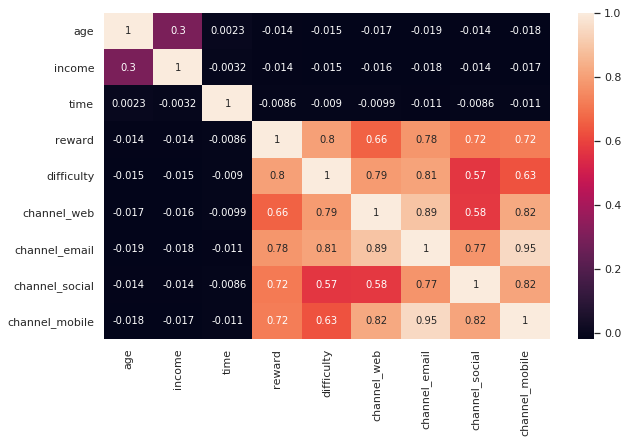

In [129]:
cormat = df1.corr()
plt.figure(figsize=(10,6))
sns.heatmap(cormat,annot=True)

In [130]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272772 entries, 0 to 272771
Data columns (total 15 columns):
id                  272772 non-null object
became_member_on    272772 non-null object
gender              272772 non-null object
age                 272772 non-null float64
income              272772 non-null float64
event               272772 non-null object
value               272772 non-null object
time                272772 non-null float64
reward              272772 non-null float64
difficulty          272772 non-null float64
offer_type          272772 non-null object
channel_web         272772 non-null float64
channel_email       272772 non-null float64
channel_social      272772 non-null float64
channel_mobile      272772 non-null float64
dtypes: float64(9), object(6)
memory usage: 43.3+ MB


In [131]:
dummies = pd.get_dummies(df1.offer_type)
dummies.head()

,0,bogo,discount,informational
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [132]:
df2 = pd.concat([df1,dummies],axis='columns')
df2.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,channel_mobile,0,bogo,discount,informational
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1,0,0,0


In [133]:
dummies = pd.get_dummies(df2.gender)
dummies.head()

,0,F,M,O
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [134]:
df3 = pd.concat([df2,dummies],axis='columns')
df3.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,...,channel_social,channel_mobile,0,bogo,discount,informational,0,F,M,O
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,0.0,0.0,...,0.0,0.0,1,0,0,0,0,1,0,0


In [135]:
dummies=pd.get_dummies(df3.event)
dummies.head()

,0,offer completed,offer received,offer viewed,transaction
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,0,1


In [136]:
final = pd.concat([df3,dummies],axis='columns')
final.head()

,id,became_member_on,gender,age,income,event,value,time,reward,difficulty,...,informational,0,F,M,O,0,offer completed,offer received,offer viewed,transaction
0,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 21.51},18.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 32.28},144.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,0610b486422d4921ae7d2bf64640c50b,1970-01-01 00:00:00.020170715,F,55.0,112000.0,transaction,{'amount': 23.22},528.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [137]:
final.drop(columns=['id','became_member_on','gender','value','informational','event'],axis=1,inplace=True)
final.head()

,age,income,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,channel_mobile,...,discount,0,F,M,O,0,offer completed,offer received,offer viewed,transaction
0,55.0,112000.0,18.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,55.0,112000.0,144.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,55.0,112000.0,408.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,55.0,112000.0,504.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,55.0,112000.0,528.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [138]:
final.head()

,age,income,time,reward,difficulty,offer_type,channel_web,channel_email,channel_social,channel_mobile,...,discount,0,F,M,O,0,offer completed,offer received,offer viewed,transaction
0,55.0,112000.0,18.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,55.0,112000.0,144.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,55.0,112000.0,408.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,55.0,112000.0,504.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
4,55.0,112000.0,528.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [139]:
final.drop(columns=['offer_type'],axis=1,inplace=True)
final.head()

,age,income,time,reward,difficulty,channel_web,channel_email,channel_social,channel_mobile,0,...,discount,0,F,M,O,0,offer completed,offer received,offer viewed,transaction
0,55.0,112000.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,1,0,0,0,0,0,0,1
1,55.0,112000.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,1,0,0,0,0,0,0,1
2,55.0,112000.0,408.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,1,0,0,0,0,1,0,0
3,55.0,112000.0,504.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,1,0,0,0,0,1,0,0
4,55.0,112000.0,528.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,1,0,0,0,0,0,0,1


In [140]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272772 entries, 0 to 272771
Data columns (total 21 columns):
age                272772 non-null float64
income             272772 non-null float64
time               272772 non-null float64
reward             272772 non-null float64
difficulty         272772 non-null float64
channel_web        272772 non-null float64
channel_email      272772 non-null float64
channel_social     272772 non-null float64
channel_mobile     272772 non-null float64
0                  272772 non-null uint8
bogo               272772 non-null uint8
discount           272772 non-null uint8
0                  272772 non-null uint8
F                  272772 non-null uint8
M                  272772 non-null uint8
O                  272772 non-null uint8
0                  272772 non-null uint8
offer completed    272772 non-null uint8
offer received     272772 non-null uint8
offer viewed       272772 non-null uint8
transaction        272772 non-null uint8
dtypes: fl

In [141]:
X = final.drop('offer completed', axis =1) # input variables
y = final["offer completed"]# output variables

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)

In [143]:
logmodel=LogisticRegression()

In [144]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [145]:
logmodel.score(X_test,y_test)

0.88105581523233434

In [146]:
from sklearn.metrics import accuracy_score, f1_score
predictions = logmodel.predict(X_test)

In [147]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94     48066
          1       0.00      0.00      0.00      6489

avg / total       0.78      0.88      0.83     54555



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [148]:
accuracy_score(y_test,predictions)

0.88105581523233434

In [150]:
from sklearn.metrics import confusion_matrix


In [151]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfc,X_test,y_test)

ImportError: cannot import name 'plot_confusion_matrix'

In [152]:
confusion_matrix(y_test,predictions)

array([[48066,     0],
       [ 6489,     0]])

In [153]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     48066
          1       1.00      1.00      1.00      6489

avg / total       1.00      1.00      1.00     54555



In [155]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [156]:
GradientBoostingClassifier()

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [ ]:
print(classification_report(y_test,model.predict(X_test)))